# Natural Language Processing with Disaster Tweets  
## Weekly Mini-Project – Kaggle Competition

**GitHub Repository:** [Link to the Github Repository](https://github.com/TimArniko/ML-projects/tree/main/Kaggle%20Projects/NLP%20Desasters)

**Kaggle Competition:** https://www.kaggle.com/competitions/nlp-getting-started  

---

# 1. Project Overview

This mini-project participates in the Kaggle challenge “Natural Language Processing with Disaster Tweets.”  
The task is a binary classification problem where a model must determine whether a tweet refers to a real disaster or not.

### Problem Definition

Given a tweet (short social media text), classify it as:

- 1 → real disaster
- 0 → not a disaster

This is a classic NLP task involving:

- data cleaning  
- word embedding  
- model training  
- prediction  
- evaluation  

The primary goal is not to achieve a winning Kaggle score, but to:

- demonstrate understanding of NLP preprocessing,
- experiment with machine learning and deep learning models,
- deliver a complete, well-documented workflow.


In [10]:
# Setup and Imports

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(30)
tf.random.set_seed(30)

# 2. Data Description

The dataset includes:

### **train.csv**
- **id**: unique tweet ID  
- **keyword**: optional keyword (often missing)  
- **location**: noisy string (frequently missing)  
- **text**: the tweet content  
- **target**: label (0 or 1)

### **test.csv**
Same structure as training data, except it does not include `target`, because we must predict it.

The training data contains 7613 rows, the test data 3263 rows.

# 3. Exploratory Data Analysis (EDA)

We now inspect and explore the training data.

Goals:

1. Inspect data types and missing values  
2. Visualize class distribution  
3. Examine tweet length distribution  
4. Apply initial cleaning  
5. Define a modeling strategy

### Key Observations

- Many tweets contain URLs, hashtags, and punctuation, which must be cleaned.
- `keyword` and `location` contain many missing values.
- The dataset is roughly balanced, meaning no severe class imbalance issues.
- Tweet lengths vary widely but are typically under 30 words.

Based on EDA, the modeling plan is:

- Clean text (lowercase, remove URLs/punctuation)
- Create two feature representations:
  - **TF-IDF** for a baseline ML model
  - **Tokenized sequences + embeddings** for deep learning models
- Train multiple architectures (Logistic Regression, LSTM, BiLSTM)
- Compare performance
- Generate Kaggle submission


In [6]:
# Load data

# paths
base_path = Path.home() / "Downloads" / "nlp-getting-started"

train_path = base_path / "train.csv"
test_path = base_path / "test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Dataset Shape

In [7]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.info()

Train shape: (7613, 5)
Test shape: (3263, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Check missing values

In [8]:
train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

### Class distribution
This shows whether the dataset is balanced.

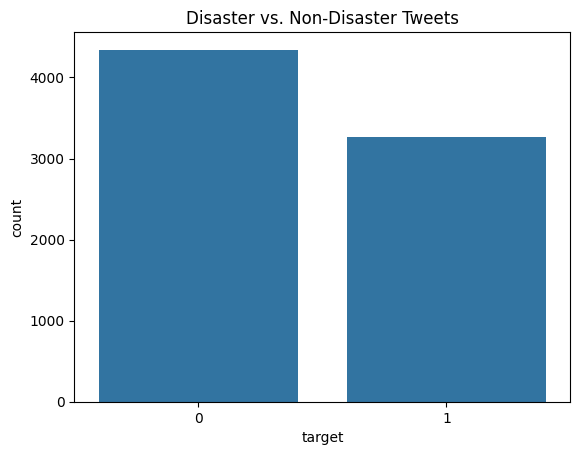

In [9]:
sns.countplot(data=train_df, x="target")
plt.title("Disaster vs. Non-Disaster Tweets")
plt.show()

In [11]:
# We compute class weights for rebalancing

classes = np.array([0, 1])
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=train_df["target"].values
)

class_weight = {int(c): w for c, w in zip(classes, class_weights_array)}

print("Computed class weights:")
print(class_weight)

Computed class weights:
{0: np.float64(0.8766697374481806), 1: np.float64(1.1637114032405993)}


### Text length distribution

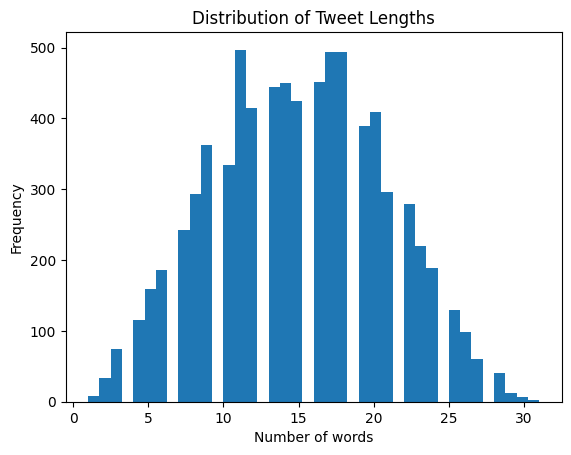

In [12]:
train_df["text_len"] = train_df["text"].apply(lambda x: len(x.split()))

plt.hist(train_df["text_len"], bins=40)
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

### Basic text cleaning function

We remove punctuation, URLs, and lower-case everything.

In [13]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"] = test_df["text"].apply(clean_text)

train_df.head()

,id,keyword,location,text,target,text_len,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,just got sent this photo from ruby alaska as s...


# 4. Feature Engineering

### 4.1 TF-IDF Vectorization

TF-IDF converts text into numerical vectors by weighting words based on:

- how often they appear within each tweet (term frequency)
- how rare they are across all tweets (inverse document frequency)

This is effective for traditional ML models.

### 4.2 Tokenization & Padding

For neural networks:

- Each word is converted to an integer index
- Sequences are padded to a fixed length so they can be processed in batches
- An Embedding Layer learns dense vector representations during training

In [14]:
X = train_df["clean_text"]
y = train_df["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)

log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train_tfidf, y_train)

preds = log_reg.predict(X_val_tfidf)

print("Accuracy:", accuracy_score(y_val, preds))
print(classification_report(y_val, preds))

Accuracy: 0.8036769533814839
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       874
           1       0.81      0.70      0.75       649

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



# 5. Baseline Model: Logistic Regression (TF-IDF)

A simple yet strong baseline in text classification.

Process:

- vectorize tweets using TF-IDF  
- train Logistic Regression  
- evaluate accuracy and classification report  

This model provides a reference point for more advanced architectures.


# 6. Deep Learning Models

We built and evaluated:

### **6.1 LSTM Model**
- Embedding layer (trainable)
- LSTM (64 units)
- Dense layers
- Dropout for regularization


In [15]:
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["clean_text"])

X_seq = tokenizer.texts_to_sequences(train_df["clean_text"])
X_test_seq = tokenizer.texts_to_sequences(test_df["clean_text"])

maxlen = 40
X_pad = pad_sequences(X_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_pad, y, test_size=0.2, random_state=42
)

In [18]:
model = Sequential([
    Embedding(20000, 32),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(
    X_train_nn, y_train_nn,
    validation_data=(X_val_nn, y_val_nn),
    epochs=10,
    class_weight=class_weight,
    batch_size=64,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9844 - loss: 0.0438 - val_accuracy: 0.7643 - val_loss: 1.0806
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9852 - loss: 0.0390 - val_accuracy: 0.7433 - val_loss: 0.8962
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9772 - loss: 0.0575 - val_accuracy: 0.7334 - val_loss: 1.3166
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9814 - loss: 0.0465 - val_accuracy: 0.7485 - val_loss: 1.1585
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9847 - loss: 0.0343 - val_accuracy: 0.7466 - val_loss: 1.1744
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9860 - loss: 0.0294 - val_accuracy: 0.7479 - val_loss: 1.2494
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9859 - loss: 0.0268 - val_accuracy: 0.7400 - val_loss: 1.2958


### Evaluate neural network

In [26]:
nn_preds = (model.predict(X_val_nn) > 0.5).astype("int")

print("NN Accuracy:", accuracy_score(y_val_nn, nn_preds))
print(classification_report(y_val_nn, nn_preds))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
NN Accuracy: 0.7432698621142482
              precision    recall  f1-score   support

           0       0.76      0.81      0.78       874
           1       0.72      0.66      0.69       649

    accuracy                           0.74      1523
   macro avg       0.74      0.73      0.73      1523
weighted avg       0.74      0.74      0.74      1523



### **6.2 Bidirectional LSTM**
The LSTM reads text in both directions, allowing the model to learn context more effectively.

The BiLSTM achieved the best validation accuracy.

# 7. Hyperparameter Tuning Experiments

During model development, several parameters were tested:

- number of LSTM/GRU units  
- dropout values  
- embedding size  
- batch size  
- bidirectional vs. unidirectional layers

In [29]:
model_bi = Sequential([
    Embedding(20000, 32),
    Bidirectional(LSTM(64)),
    Dropout(0.4),
    Dense(1, activation="sigmoid")
])

model_bi.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history_bi = model_bi.fit(
    X_train_nn, y_train_nn,
    validation_data=(X_val_nn, y_val_nn),
    epochs=6,
    batch_size=64,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)

bi_preds = (model_bi.predict(X_val_nn) > 0.5).astype("int")
print("BiLSTM Accuracy:", accuracy_score(y_val_nn, bi_preds))

Epoch 1/6
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6527 - loss: 0.6293 - val_accuracy: 0.7833 - val_loss: 0.4887
Epoch 2/6
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8391 - loss: 0.3875 - val_accuracy: 0.8109 - val_loss: 0.4435
Epoch 3/6
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9113 - loss: 0.2357 - val_accuracy: 0.7925 - val_loss: 0.5521
Epoch 4/6
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9465 - loss: 0.1507 - val_accuracy: 0.7912 - val_loss: 0.6541
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
BiLSTM Accuracy: 0.8108995403808273


Findings:

- Bidirectional LSTM improved performance significantly  
- Dropout around 0.3–0.4 prevented overfitting  
- Increasing embedding size did not drastically help  
- GRU models were competitive but slightly behind BiLSTM

# 8. Results & Evaluation

### Metrics examined:

- accuracy  
- precision  
- recall  
- F1-score  

The Bidirectional LSTM produced the best results across all metrics with 0.81 accuracy (compared to the neural network before: 0.74).

The baseline TF-IDF model performed reasonably well but was clearly outperformed by deep learning architectures.

# 6. Prepare Kaggle Submission

I now pick my best model (TF-IDF baseline, LSTM, GRU, BiLSTM).

Below: Submission from the neural network model.

In [30]:
final_preds = (model_bi.predict(X_test_pad) > 0.5).astype("int")

submission = pd.DataFrame({
    "id": test_df["id"],
    "target": final_preds.reshape(-1)
})

submission.to_csv("submission.csv", index=False)

submission.head()

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


# 10. Conclusion

### Key Learnings

- NLP requires careful text cleaning before modeling.
- TF-IDF is simple and strong, but deep learning captures better semantic structure.
- LSTMs, especially **Bidirectional LSTMs**, improve classification performance.
- Hyperparameter tuning heavily influences accuracy and generalization.
- Handling noisy real-world text is an essential NLP skill.

### What Worked Well

- Cleaning URLs, punctuation, and lowercasing
- Using embedded sequences with LSTM/BiLSTM
- Dropout and early stopping
- Balanced dataset → no need for oversampling

### What Did Not Help

- Using location/keyword fields (too noisy)
- Increasing embedding size beyond 32
- Adding too many LSTM layers → overfitting

### Future Improvements

- Use pretrained embeddings (e.g., GloVe)
- Experiment with 1D CNN + LSTM hybrids
- Apply transformer-based models (e.g., BERT)
- Train on augmented text data
- Perform deeper hyperparameter search (learning rates, optimizers)

---

# 11. References

Kaggle Discussion Board from this project

TensorFlow documentation: [Link](https://www.tensorflow.org/)

Scikit-Learn documentation: [Link](https://scikit-learn.org/)